# Triple Barrier Method Application

This notebook develops Exercise 3.1 proposed in AFML

- From S&P 500 futures compute dollar bars
- Apply a symmetric CUSUM filter using the standard deviation of daily returns as threshold
- Use a TBM with vertical barries with numDays == 1 and a symmetric multipliers for TP/SL

In [4]:
#general purpose imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

#specific imports
scripts_path = Path("../00_books/AFML/scripts").resolve()
sys.path.append(str(scripts_path))
from AFML_book_scripts import *
from AFML_my_scripts import *

## Get Data and Build Dollar Bars

In [214]:
#import tick data
data = pd.read_csv('../00_books/AFML/data/SP_futures_tick_data.csv')

In [215]:
data

,date,time,price,volume
0,01/03/2000,08:30:34.000,1496.4,0
1,01/03/2000,08:30:36.000,1496.0,0
2,01/03/2000,08:30:37.000,1495.5,0
3,01/03/2000,08:30:46.000,1495.0,0
4,01/03/2000,08:30:53.000,1495.5,0
...,...,...,...,...
13802497,12/31/2019,15:00:02.086,3232.0,0
13802498,12/31/2019,15:00:09.277,3231.5,0
13802499,12/31/2019,15:00:14.203,3230.5,0
13802500,12/31/2019,15:01:09.088,3233.0,0


In [217]:
#manipulate data such that we can transfomr into a dollar bar series
datetime_str = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')

In [ ]:
#only between 2002 and 2012
start_date = '2002-01-01'
end_date = '2012-12-31'
data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]

In [259]:
#get the dollar bar dataframe
dollars_bars_size = 1000000  
df = DollarBarsDfVectorized(data, dollar_per_bar=dollars_bars_size)

## Apply Symmetric CUSUM Filter

In [260]:
# reindex the dataframe to datetime as we will need timeindexed series objects
df = df.drop('start_date', axis=1 )
df = df.rename(columns={'end_date': 'datetime'})
df = df.set_index('datetime')
#drop eventual duplciate indices
df = df[~df.index.duplicated(keep='first')]

In [261]:
#calcualte threshold for CUSUM as std of returns
threshold = df.close.diff().std()

In [262]:
# get CUSUM events using the defined function
CUSUM_events = get_CUSUM_events(gRaw=df.close, h = threshold)
CUSUM_events.shape

(3043,)

## Add Vertical Barrier & Volatility for Target Barriers

In [284]:
numDays = 1
t1=df.close.index.searchsorted(CUSUM_events+pd.Timedelta(days=numDays))
t1=t1[t1<df.close.shape[0]]
t1=pd.Series(df.close.index[t1],index=CUSUM_events[:t1.shape[0]])

In [285]:
target = GetTargetforTBM(df.close, ema_periods=20)

## Set Up TBM

In [293]:
#symmetric pt/sl multipliers
tpsl = (1, 1)
#min return for target as k times the mean of target itself
mean_mulitplier = 1.5
min_return = mean_mulitplier*target.mean()

In [294]:
filtered_events = getEvents(close=df.close, tEvents=CUSUM_events, ptSl = tpsl, 
                            trgt= target, minRet = min_return, t1=t1)

filtered_events

IndexError: list index out of range

In [295]:
labels = getTBMLabels(filtered_events, df.close)

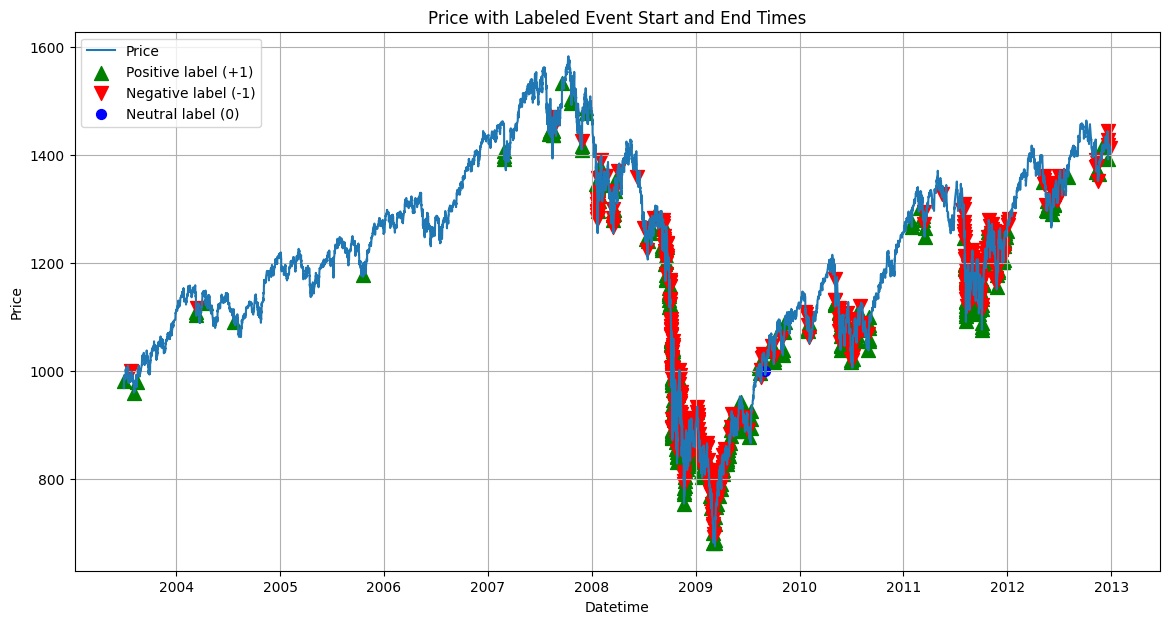

In [296]:
events_labeled = labels
close_plot = df.close

plt.figure(figsize=(14,7))
plt.plot(close_plot.index, close_plot.values, label='Price')

# Filter events by label within the plotting range
pos_events = events_labeled[(events_labeled['bin'] == 1) & (events_labeled.index.isin(close_plot.index))]
neg_events = events_labeled[(events_labeled['bin'] == -1) & (events_labeled.index.isin(close_plot.index))]
neutral_events = events_labeled[(events_labeled['bin'] == 0) & (events_labeled.index.isin(close_plot.index))]

# Plot event markers on price chart
plt.scatter(pos_events.index, close_plot.loc[pos_events.index], color='green', marker='^', label='Positive label (+1)', s=100)
plt.scatter(neg_events.index, close_plot.loc[neg_events.index], color='red', marker='v', label='Negative label (-1)', s=100)
plt.scatter(neutral_events.index, close_plot.loc[neutral_events.index], color='blue', marker='o', label='Neutral label (0)', s=50)


plt.legend()
plt.title('Price with Labeled Event Start and End Times')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.grid(True)
plt.show()


MODFY GETEVENTS GETTMBLABELS TO INCLUDE LABEL 0 WHEN VB IS HIT 